# Building and Fine-Tuning Internal Chatbot

**Tracking training metrics on HuggingFace**

In [ ]:
#Installing required packages
# type: ignore

!pip install -U fsspec==2023.6.0 datasets==2.18.0
!pip install datasets s3fs gcsfs --upgrade
!pip install -q transformers datasets accelerate peft bitsandbytes trl sentence-transformers langchain faiss-cpu gradio pymupdf langchain_huggingface wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 40.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
# type: ignore

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, logging, TextStreamer
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch, wandb, platform, gradio, warnings
from datasets import load_dataset
from trl import SFTTrainer
#from huggingface_hub import notebook_login

# Note: The 'pipeline' module was removed from the import statement due to
# a compatibility issue with the installed versions of torch and torchvision.
# If you require the 'pipeline' module, you may need to adjust your environment
# or library versions to resolve the conflict.

In [ ]:
# Load dataset -- It contains 52K instruction-following data generated by GPT-4 using the same prompts as in Alpaca
dataset_name = "vicgalle/alpaca-gpt4"
dataset = load_dataset(dataset_name, split="train[0:10000]")
dataset["text"][0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-6ef3991c06080e14.parquet:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGive three tips for staying healthy.\n\n### Response:\n1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'

In [ ]:
#Config and Tokenizer
# type: ignore

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

model_id = "openchat/openchat-3.5-0106"

bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"": 0})
model = prepare_model_for_kbit_training(model)
model.config.use_cache = False # silence the warnings. Please re-enable for inference!
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.add_bos_token, tokenizer.add_eos_token

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

(True, True)

In [ ]:
#LORA Config
peft_config = LoraConfig(
    lora_alpha= 8,
    lora_dropout= 0.1,
    r= 16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj", "up_proj"]
)

#Training/Fine-Tuning Arguments/Parameters
training_arguments5 = TrainingArguments(
    output_dir= "./results",
    num_train_epochs= 1,
    per_device_train_batch_size= 8,
    gradient_accumulation_steps= 2,
    optim = "paged_adamw_8bit",
    save_steps= 1000,
    logging_steps= 10,
    learning_rate= 2e-4,
    weight_decay= 0.001,
    fp16= False,
    bf16= False,
    max_grad_norm= 0.3,
    max_steps= 100,
    warmup_ratio= 0.3,
    group_by_length= True,
    lr_scheduler_type= "linear"
)

# Setting sft parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    args=training_arguments5)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


**Model Parameters and Variable Details:**
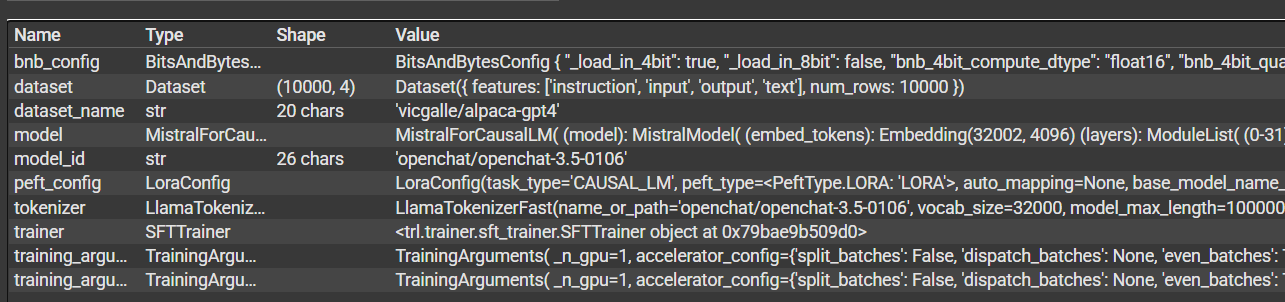

In [ ]:
# Train model --- only kept till 150 steps, otherwise takes a lot of time
#Redo with 100 steps - better accuracy seen at the 100th step

warnings.filterwarnings("ignore")
trainer.train()
#Training Accuracy (mean token): 83.4%

new_model = 'fine_tuned_qlora_v2'
# Save the fine-tuned model
trainer.model.save_pretrained(new_model)
model.config.use_cache = True
model.eval()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nea-rawat (nea-rawat-bhc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.004600
20,0.894500
30,0.875200
40,0.797800
50,0.722800
60,0.860200
70,0.825800
80,0.850300
90,0.764600
100,0.682900


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32002, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(


**Training Performance (100 steps):**

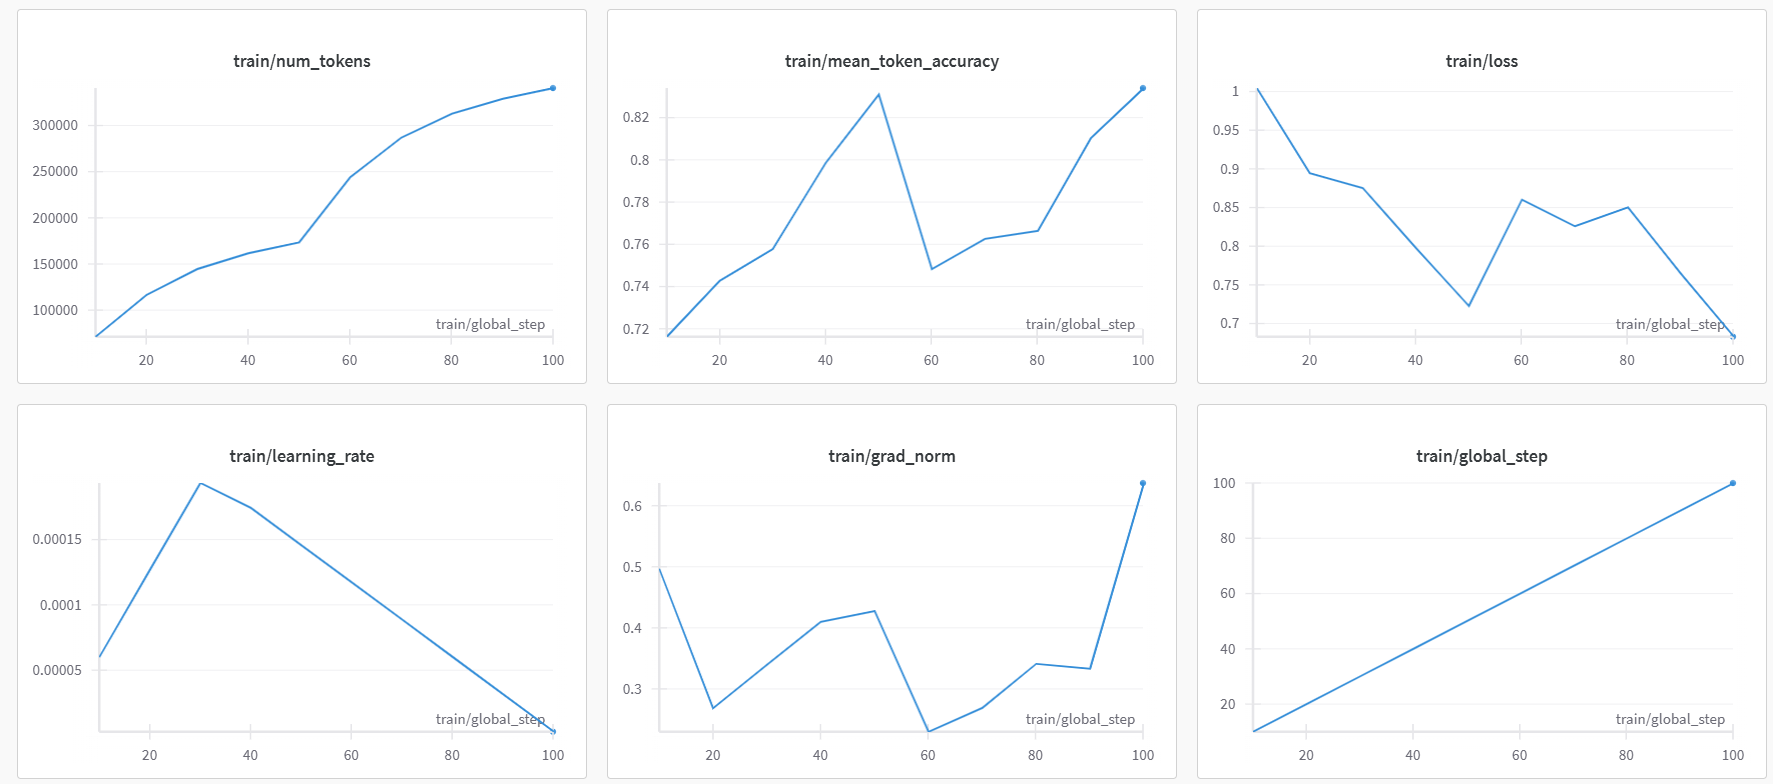

In [ ]:
#Testing the Fine-Tuned Model

def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n'
    B_INST, E_INST = "### Instruction:\n", "### Response:\n"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n\n{E_INST}"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = model.generate(**inputs, streamer=streamer, max_new_tokens=500)

In [ ]:
#from IPython.display import display, HTML, Markdown

stream("what are newton's laws of motions")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Newton's laws of motion are three fundamental principles that describe the relationship between the motion of an object and the forces acting upon it. They are as follows:

1. Newton's First Law: An object at rest will stay at rest, and an object in motion will stay in motion with the same speed and in the same direction, unless acted upon by an unbalanced external force.

2. Newton's Second Law: The acceleration of an object is directly proportional to the net force acting upon it, and inversely proportional to its mass. Mathematically, this can be expressed as F = m*a, where F is the net force, m is the mass of the object, and a is its acceleration.

3. Newton's Third Law: For every action, there is an equal and opposite reaction. This means that when one object exerts a force on another, the second object exerts an equal and opposite force back on the first object.


In [ ]:
stream("what is a non disclosure agreement")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


A non-disclosure agreement (NDA) is a legal document that is used to protect confidential information shared between two or more parties. It is a legally binding agreement that outlines the terms and conditions under which the information may be shared, used, and disclosed. The purpose of an NDA is to ensure that the confidential information is not disclosed to unauthorized individuals or used for unauthorized purposes.


In [ ]:
stream("what is the purpose of a non disclosure agreement")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


A non-disclosure agreement (NDA) is a legal document that is used to protect the confidential information of one party from being disclosed to a third party. The purpose of an NDA is to ensure that the confidential information is kept secret and not used for any unauthorized purposes.


In [ ]:
# Clear the memory footprint
del model, trainer
torch.cuda.empty_cache()